In [1]:
import pandas as pd
import folium
import sklearn.decomposition
import json

In [3]:
data_folder = "/media/sree/mars/data/road-accidents"
accidents_data_file11 = data_folder + "/accidents_2009_to_2011.csv"
accidents_data_file14 = data_folder + "/accidents_2012_to_2014.csv"

data1 = pd.read_csv(accidents_data_file11)
data2 = pd.read_csv(accidents_data_file14)


/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (31) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
data = pd.concat([data1, data2])
data['Month'] = data['Date'].apply(lambda x : str(x).split("/")[1])

## Lets isolate the accidents in one of the locations where accidents are the most common - London
data["co-ordinates"] = data.apply(lambda x: (x["Latitude"], x["Longitude"]), axis=1)
data["long_imprecise"] = data.apply(lambda x: str(x["Longitude"])[:4], axis=1)
data["lat_imprecise"] = data.apply(lambda x: str(x["Latitude"])[:4], axis=1)
data["co-ord_imprecise"] = data.apply(lambda x: (x["lat_imprecise"], x["long_imprecise"]), axis=1)

unique_coordinates = pd.unique(data["co-ord_imprecise"]).tolist()

addresses = []

## we have grabbed the address in address files
for i in range(7):
    filename = "address_list_" + str(i) 

    with open(filename,'r') as f:
        s = f.read()
        tmp = json.loads(s)
        addresses.append(tmp)


## address 
addresses_combined = [item for sublist in addresses for item in sublist]
locations = {'co_ordinates':unique_coordinates,
              'address' : addresses_combined }
locations_df = pd.DataFrame(locations, columns=['co_ordinates','address'])


In [4]:
data = pd.merge(data, locations_df, how='left', left_on='co-ord_imprecise', right_on='co_ordinates')

## Attaching city
def attach_city(x):
    try:
        return x["address"]["city"]
    except:
        return "Unknown"

data["city"] = data.apply(lambda x: attach_city(x), axis=1)

## Consider London
data_london = data[data['city'] == 'London']



In [8]:
road_types = pd.unique(data_london["Road_Type"])
print(road_types)

['One way street' 'Single carriageway' 'Dual carriageway' 'Roundabout'
 'Slip road' 'Unknown']


In [6]:
data_london.groupby(['Road_Type']).size()

Road_Type
Dual carriageway       17862
One way street          3118
Roundabout              6099
Single carriageway    123640
Slip road               1090
Unknown                   50
dtype: int64

In [11]:
years = [2009, 2010, 2011, 2012, 2013, 2014]
_data = []
[_data.append(data_london[(data_london.Year == year)]) for year in range(2009, 2015)]


[None, None, None, None, None, None]

In [34]:
road_conditions = ['Dual carriageway','One way street', 'Roundabout', 'Single carriageway',
                        'Slip road','Unknown']


road_conditions_grouped_by_year = [_data[i].groupby(['Road_Type']).size().tolist() for i in range(len(_data))]
ys = [[row[j] for row in road_conditions_grouped_by_year] for j in range(6)]

print(road_conditions_grouped_by_year)

[[2925, 425, 841, 18518, 152, 15], [2874, 438, 1002, 19331, 163, 14], [2838, 503, 960, 19599, 163, 4], [3543, 570, 1333, 27199, 237, 6], [2806, 517, 890, 18217, 172, 5], [2876, 665, 1073, 20776, 203, 6]]


In [35]:
items = pd.unique(data.Road_Type).tolist()
width = 0.15
pos = list(range(len(years)))

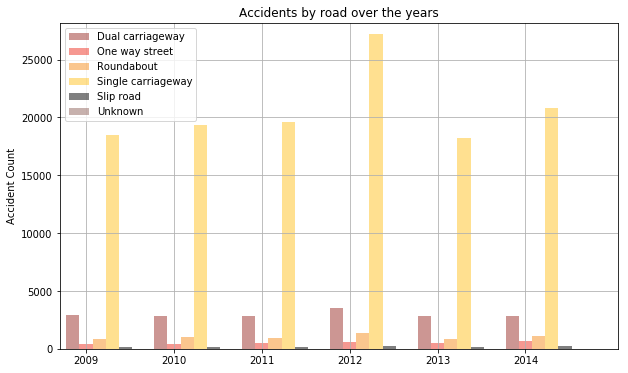

In [38]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10,6))
plt.bar(pos,ys[0], width, alpha=0.5, color='#9b2f29', label=items[0]) 
plt.bar([p + width for p in pos], ys[1],width, alpha=0.5, color='#EE3224', label=items[1]) 
plt.bar([p + width*2 for p in pos], ys[2], width, alpha=0.5, color='#F78F1E', label=items[2]) 
plt.bar([p + width*3 for p in pos], ys[3], width, alpha=0.5, color='#FFC222', label=items[3]) 
plt.bar([p + width*4 for p in pos], ys[4], width, alpha=0.5, color='#000000', label=items[4]) 
plt.bar([p + width*5 for p in pos], ys[5], width, alpha=0.5, color='#91645D', label=items[5]) 

ax.set_ylabel('Accident Count')
ax.set_title('Accidents by road over the years')
ax.set_xticks([p + 1 * width for p in pos])

# Set the labels for the x ticks
ax.set_xticklabels(years)

# Setting the x-axis and y-axis limits
plt.xlim(min(pos)-width, max(pos)+width*8)
plt.ylim([0, max(ys[0] +  ys[1] + ys[2] + ys[3] + ys[4]) + 1000])

plt.legend(road_conditions, loc='upper left')
plt.grid()
plt.show()
